WATER  QUALITY  ANALYSIS





SHERAL  SIMON   WASKAR --- 20BCE1182

ANJALI JAIN            --- 20BCE1320

# Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, KFold, train_test_split, cross_val_score)
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB  

# Importing the dataset

In [ ]:
df = pd.read_csv('water_potability.csv')

# Understanding the dataset 

In [ ]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


# Data Preprocessing

In [ ]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

<Axes: title={'center': 'Missing Values Per Feature'}>

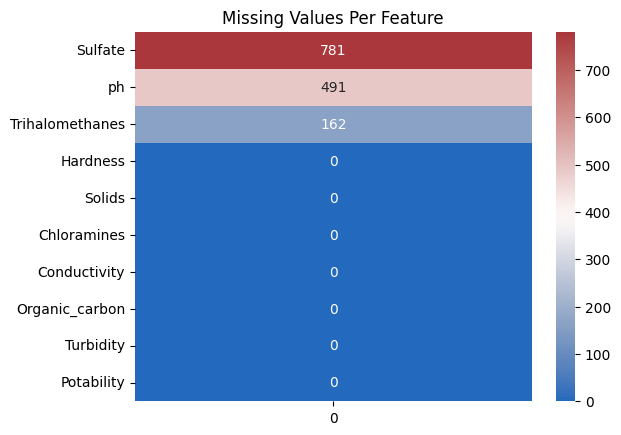

In [ ]:
plt.title("Missing Values Per Feature")
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [ ]:
#df.dropna(inplace=True)

Imputing the missing values with the mean

In [ ]:
phMean_0 = df[df['Potability'] == 0]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['ph'].isna()), 'ph'] = phMean_0
phMean_1 = df[df['Potability'] == 1]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['ph'].isna()), 'ph'] = phMean_1

##################################### Imputing 'Sulfate' value #####################################

SulfateMean_0 = df[df['Potability'] == 0]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Sulfate'].isna()), 'Sulfate'] = SulfateMean_0
SulfateMean_1 = df[df['Potability'] == 1]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Sulfate'].isna()), 'Sulfate'] = SulfateMean_1

################################ Imputing 'Trihalomethanes' value #####################################

TrihalomethanesMean_0 = df[df['Potability'] == 0]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Trihalomethanes'].isna()), 'Trihalomethanes'] = TrihalomethanesMean_0
TrihalomethanesMean_1 = df[df['Potability'] == 1]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Trihalomethanes'].isna()), 'Trihalomethanes'] = TrihalomethanesMean_1

In [ ]:
print('Checking to see any more missing data \n')
df.isna().sum()

Checking to see any more missing data 



ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

# Outlier analysis

In [ ]:
def detect_outliers_iqr(data):
  outliers=[]
  q1=np.quantile(data,0.25)
  q3=np.quantile(data,0.75)
  IQR = q3-q1
  lwr = q1-(1.5*IQR)
  upr = q3+(1.5*IQR)

  for i in data:
    if(i<lwr or i>upr):
      outliers.append(i)
  return outliers

In [ ]:
col = ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']
for i in col:
  print("Outliers in", i , ":", len(detect_outliers_iqr(df[i])))

Outliers in ph : 142
Outliers in Hardness : 83
Outliers in Solids : 47
Outliers in Chloramines : 61
Outliers in Sulfate : 264
Outliers in Conductivity : 11
Outliers in Organic_carbon : 25
Outliers in Trihalomethanes : 54
Outliers in Turbidity : 19


In [ ]:
df_cap = df.copy()
for i in col:
  Q1 = df[i].quantile(0.25)
  Q3 = df[i].quantile(0.75)
  IQR = Q3 - Q1
  upper_lim = Q3 + 1.5 * IQR
  lower_lim = Q1 - 1.5 * IQR
  df_cap[i] = np.where(df_cap[i]>upper_lim,upper_lim,np.where(df_cap[i]<lower_lim,lower_lim,df_cap[i]))
  

In [ ]:
for i in col:
  print("Outliers in ",i , " : ",len(detect_outliers_iqr(df_cap[i])))

Outliers in  ph  :  0
Outliers in  Hardness  :  0
Outliers in  Solids  :  0
Outliers in  Chloramines  :  0
Outliers in  Sulfate  :  0
Outliers in  Conductivity  :  0
Outliers in  Organic_carbon  :  0
Outliers in  Trihalomethanes  :  0
Outliers in  Turbidity  :  0


Capping the outliers to respective limit value, any value above upper limit will be replaced by upper limit and below lower limit will be replaced by lower limit.Inorder to maintain the original dimensionality the outliers are not deleted

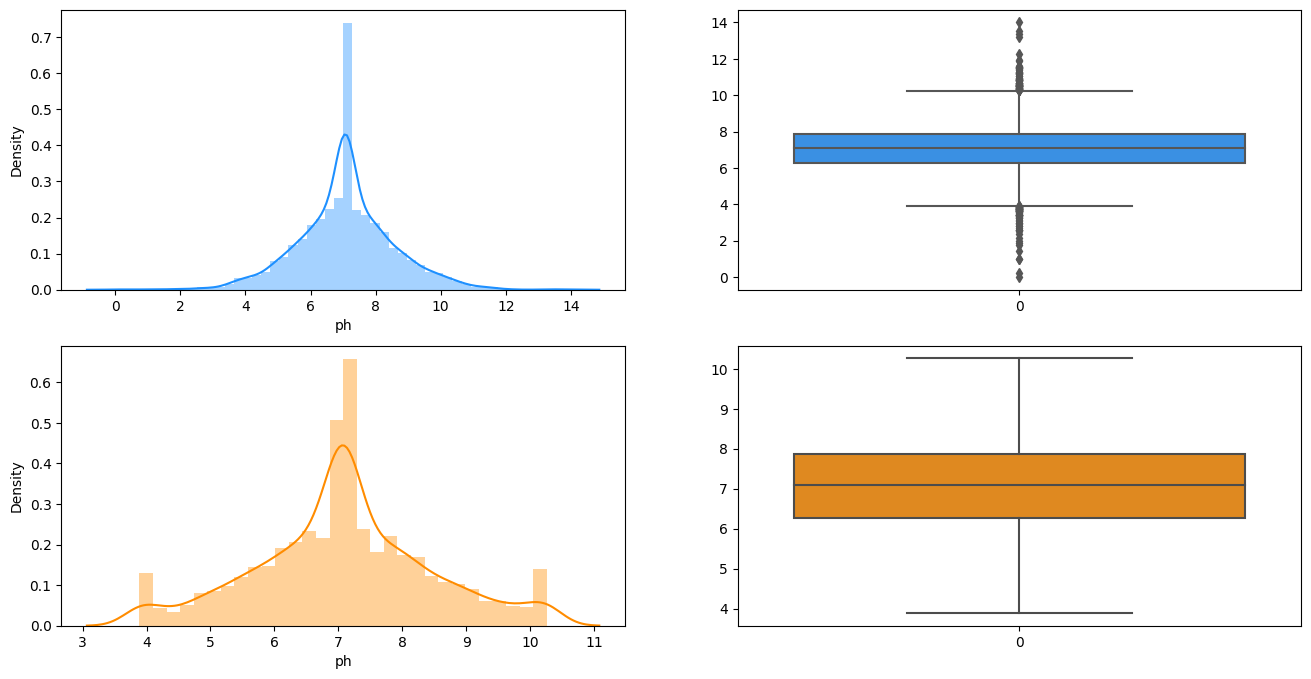

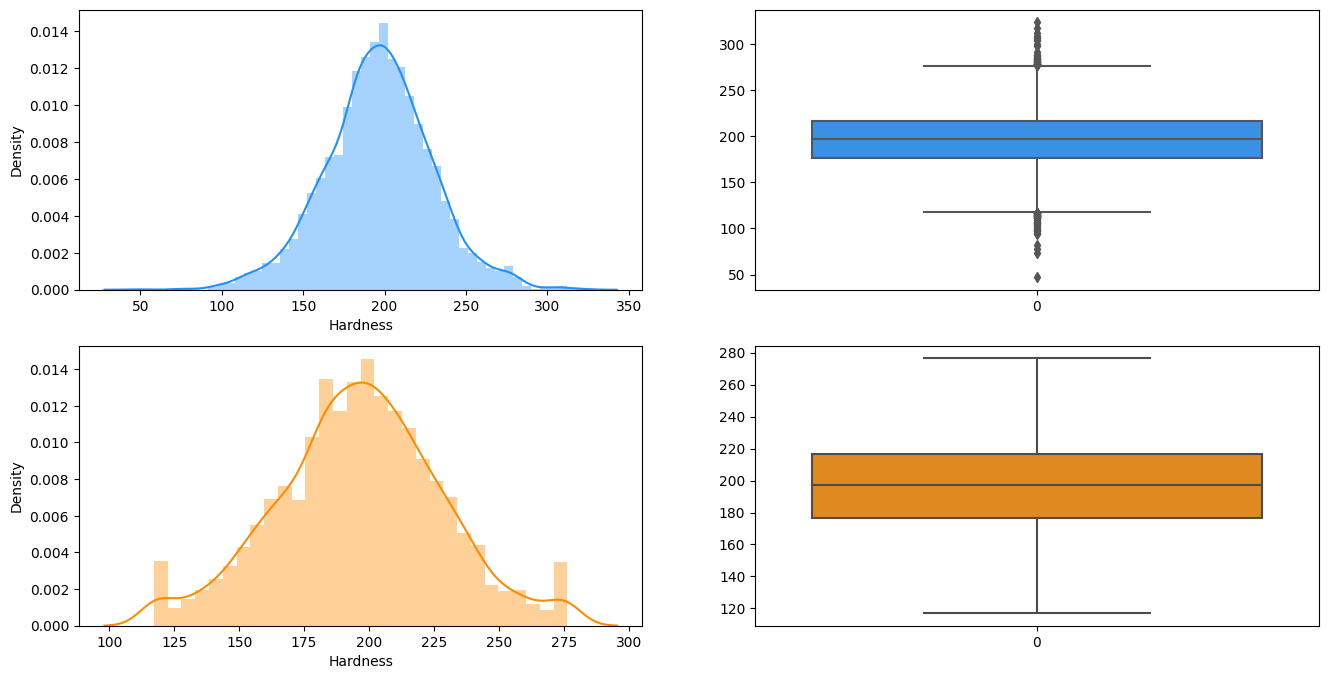

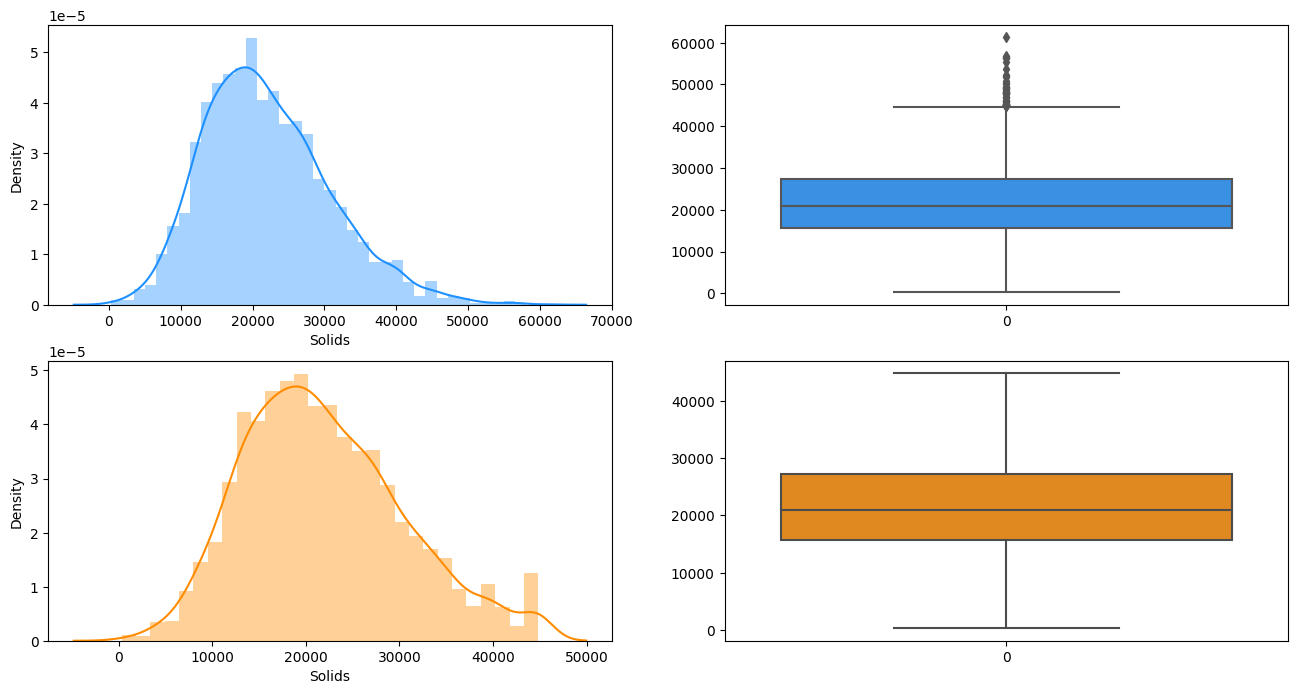

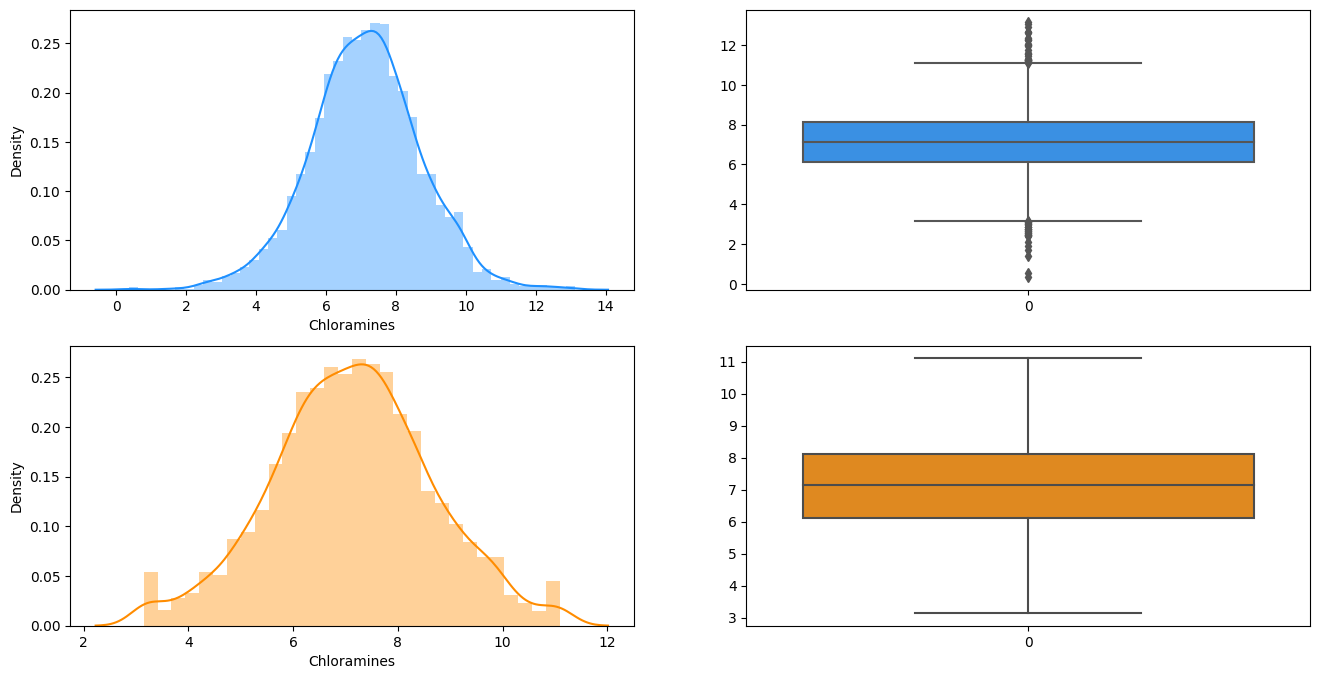

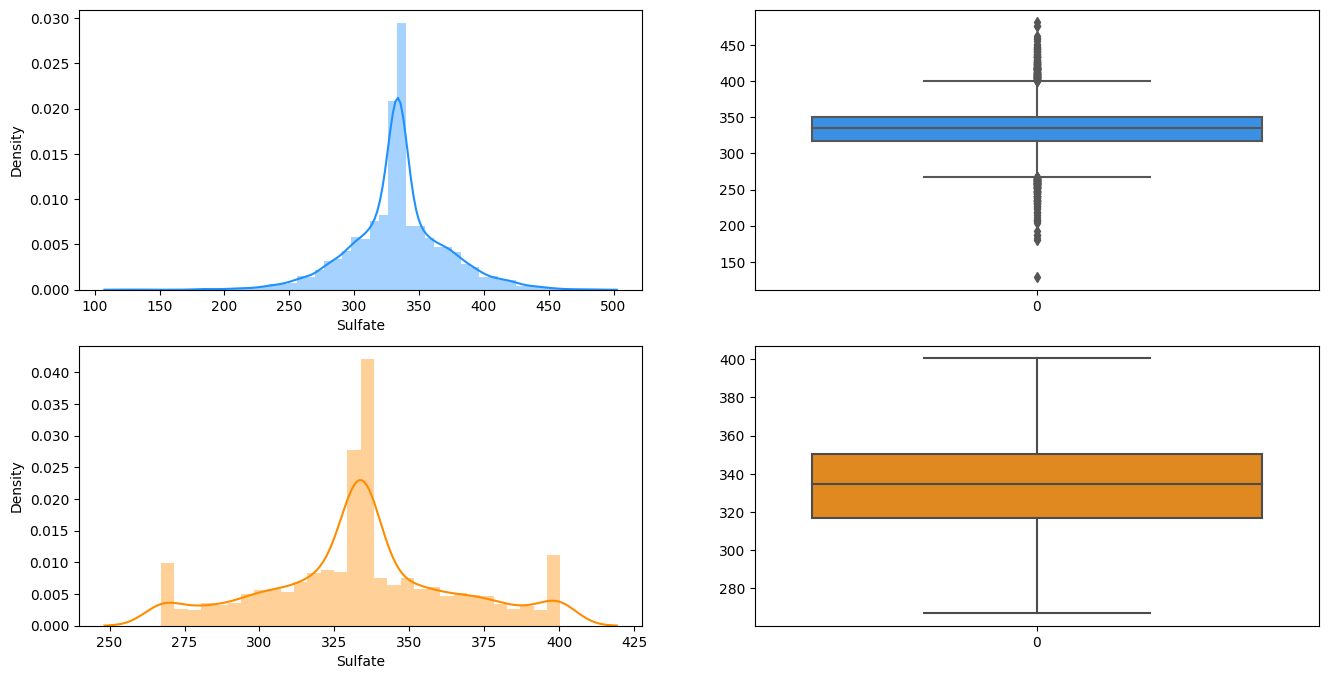

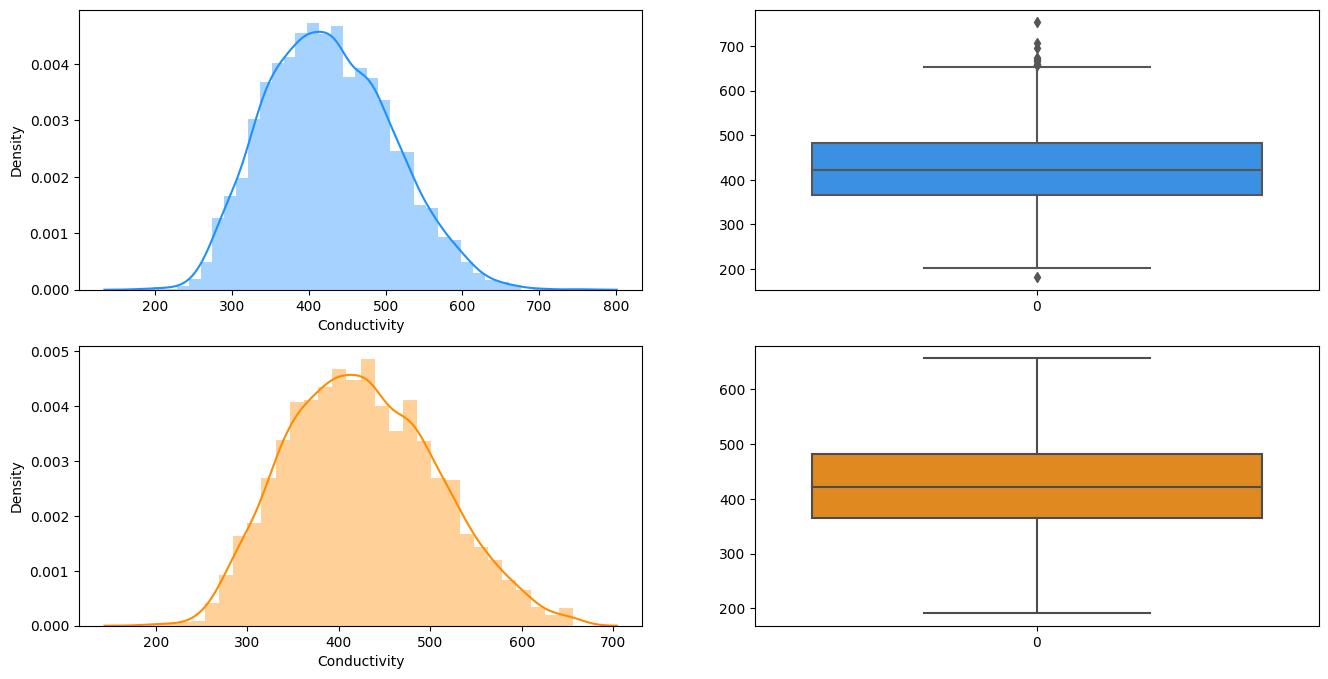

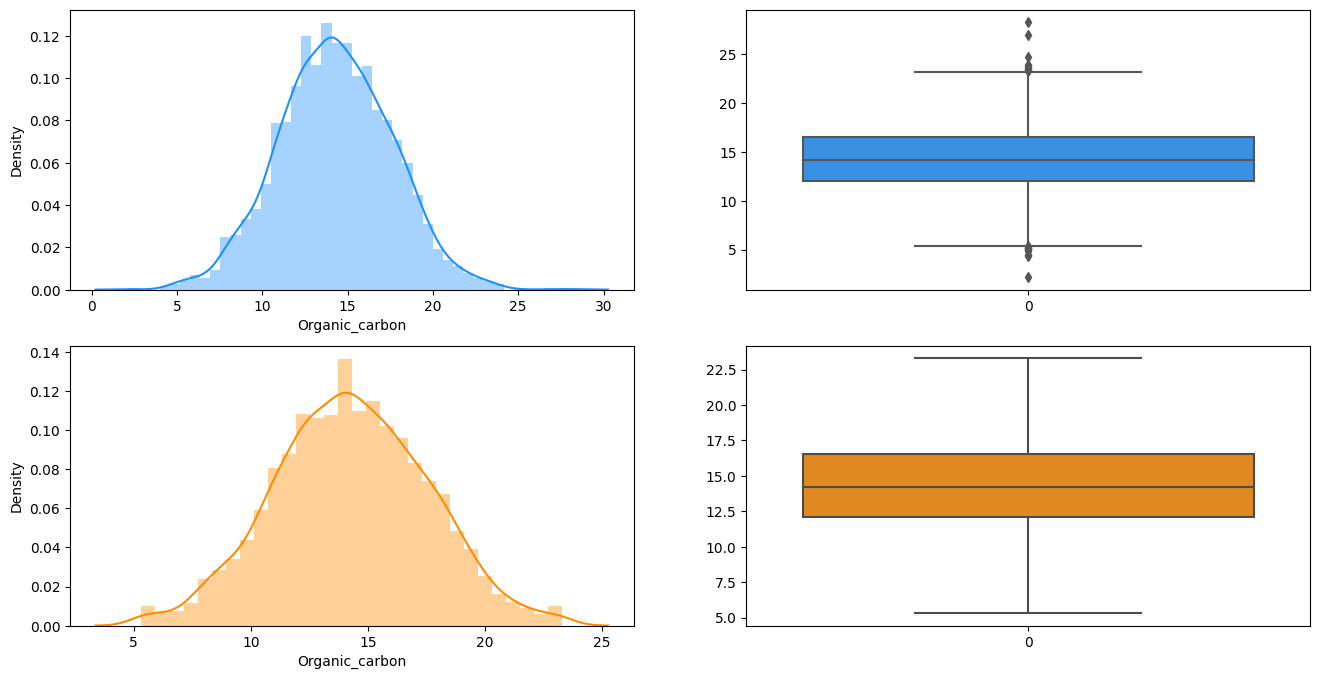

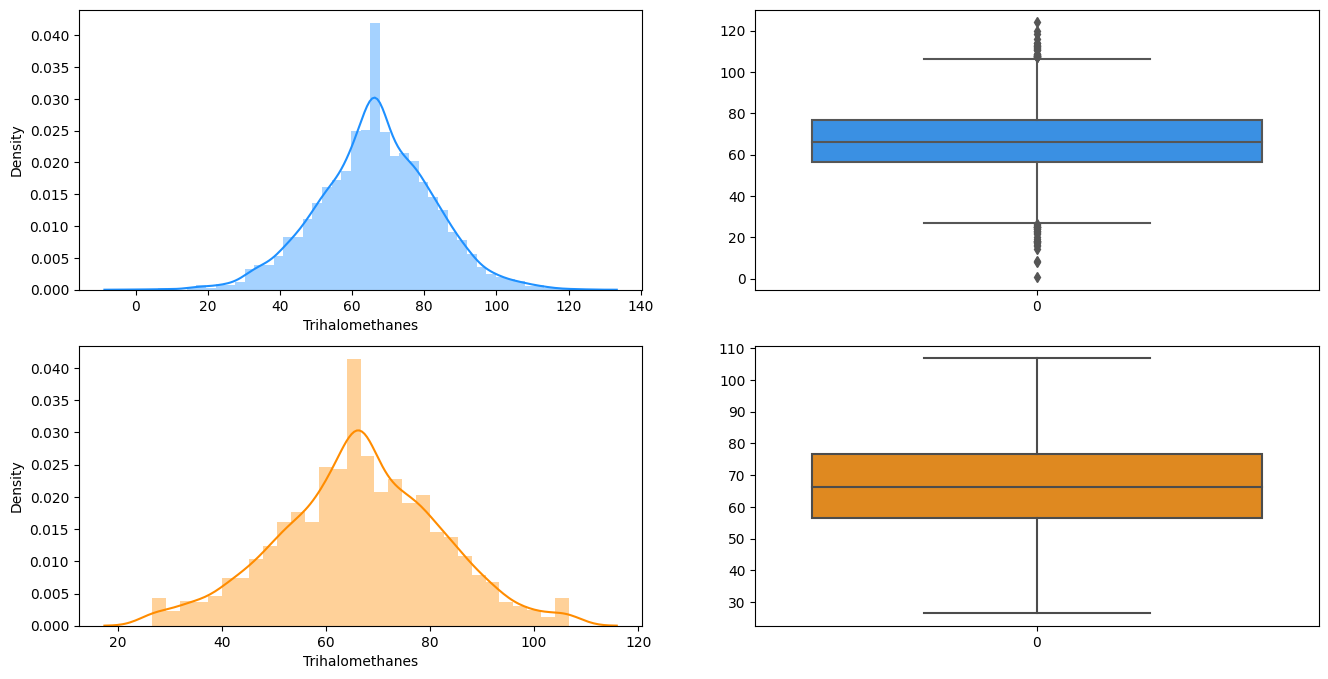

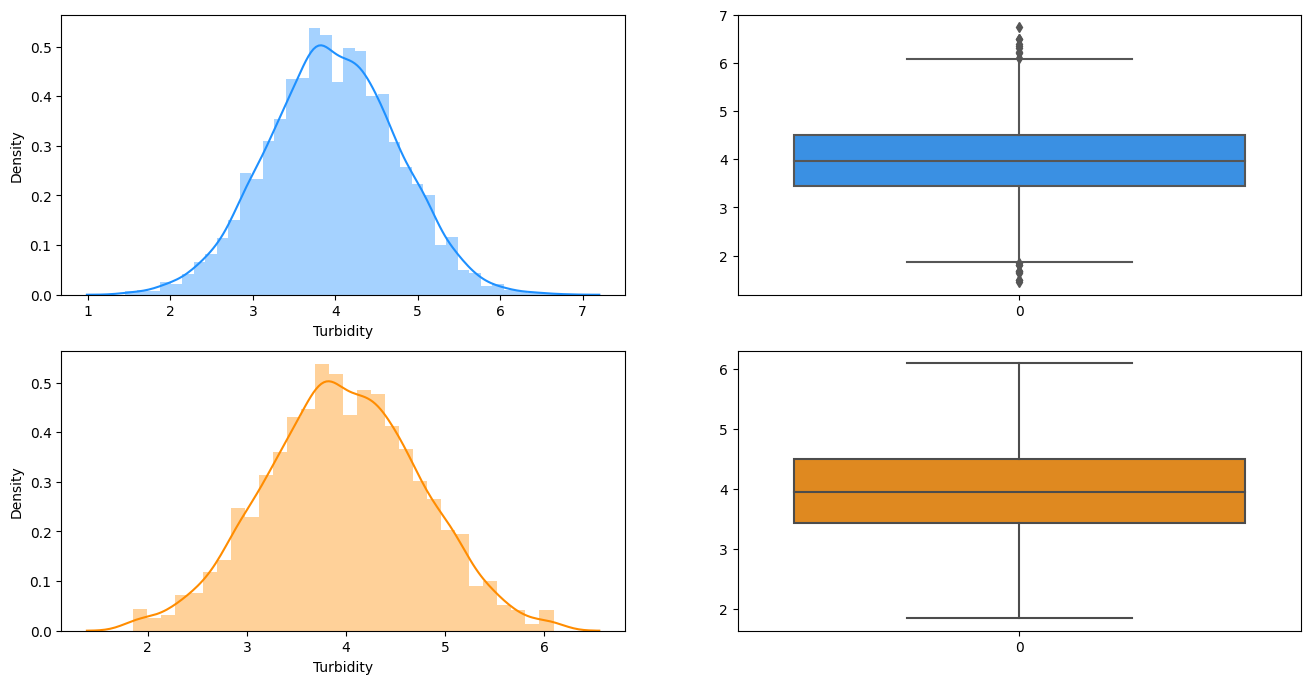

In [ ]:
for i in col:
    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    sns.distplot(df[i],color="dodgerblue")
    plt.subplot(2,2,2)
    sns.boxplot(df[i],color="dodgerblue")
    plt.subplot(2,2,3)
    sns.distplot(df_cap[i],color="darkorange")
    plt.subplot(2,2,4)
    sns.boxplot (df_cap[i],color="darkorange")
    plt.show()

# Exploratory Data Analysis

<Axes: >

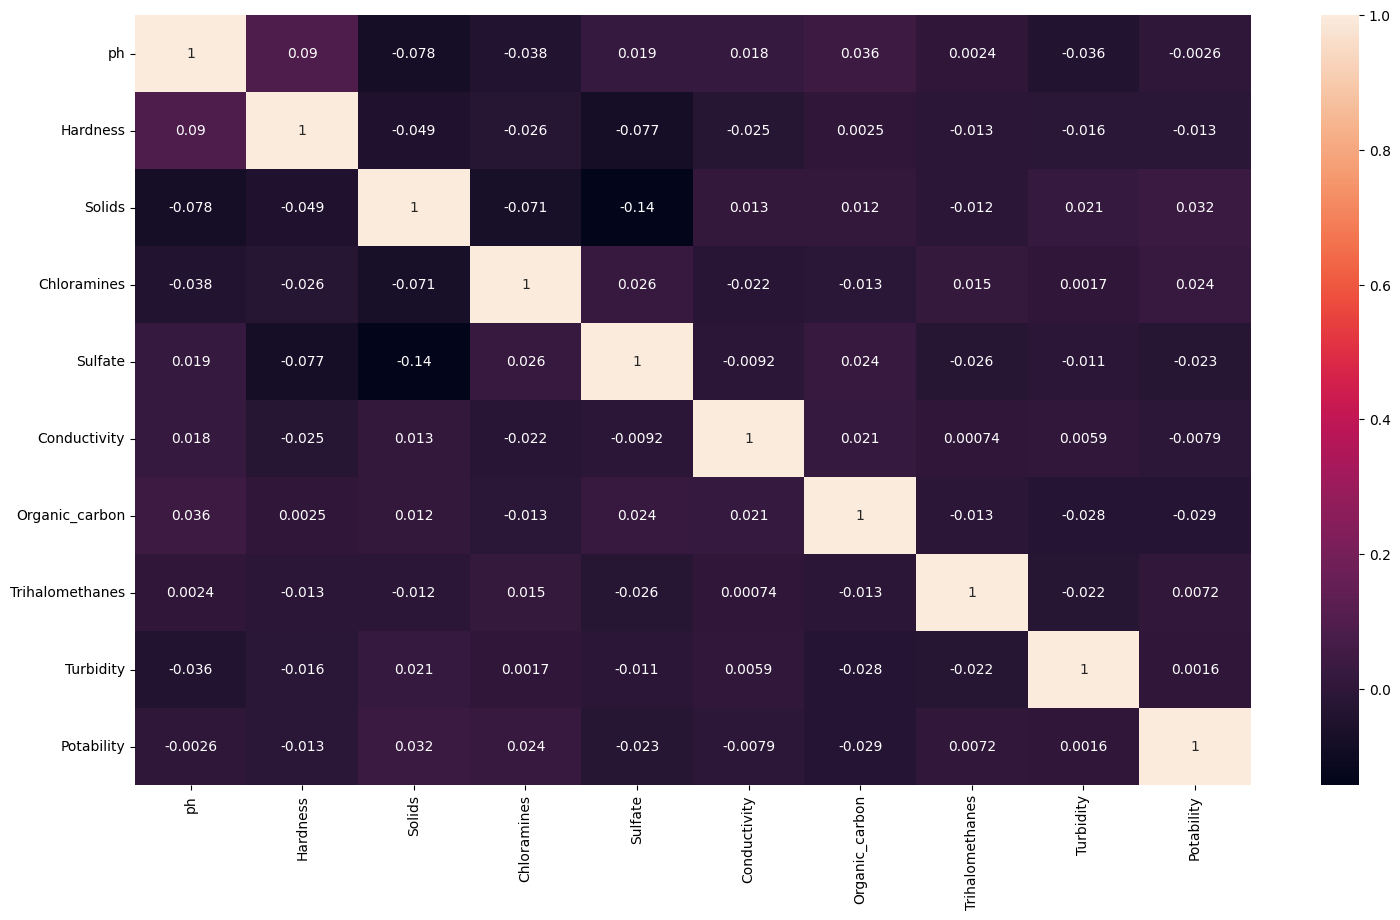

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(df_cap.corr(),cbar=True,annot=True)

It is inferred from heatmap that there is no multicollinearity which says that input variables are not interdependent to get the results

In [ ]:
#unstacking the correlation matrix to see the values more clearly
corr = df_cap.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending=False)[12:24:2]

Hardness     ph             0.089525
Solids       ph             0.077905
Sulfate      Hardness       0.076747
Chloramines  Solids         0.070861
Hardness     Solids         0.048503
ph           Chloramines    0.037994
dtype: float64

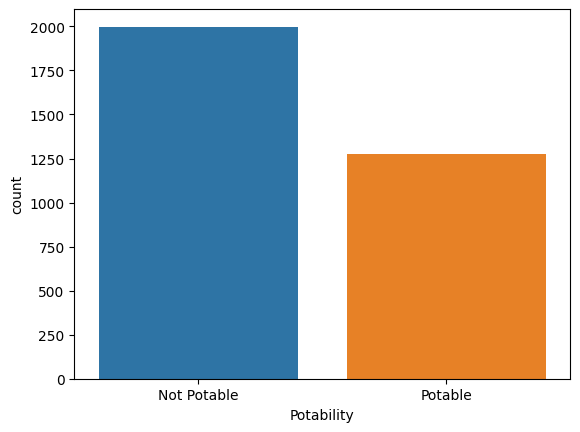

In [ ]:
#visualising the count of potable and non potable water bodies
ax = sns.countplot(x='Potability',data=df_cap,saturation=0.8)
plt.xticks(ticks=[0,1],labels=["Not Potable","Potable"])
plt.show()

In [ ]:
#interpreting the results obtained from the above visualization
x=df_cap.Potability.value_counts()
label=[0,1]
print(x)

0    1998
1    1278
Name: Potability, dtype: int64


In [ ]:
fig = px.histogram(df_cap,x='Sulfate',facet_row='Potability',template='plotly_dark')
fig.show()

In [ ]:
fig = px.histogram(df_cap,x='Trihalomethanes',facet_row='Potability',template='plotly_dark')
fig.show()

In [ ]:
fig = px.pie(df_cap,names="Potability",hole=0.4,template="plotly_dark")
fig.show()

Train Test Split

In [ ]:
X = df.drop('Potability', axis = 1).copy()
y = df['Potability'].copy()


WITHOUT OVERSAMPLING BUILDING MODELS USING K FOLD CROSS VALIDATION

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
model = [LogisticRegression(),  KNeighborsClassifier(),DecisionTreeClassifier(), GaussianNB(),BernoulliNB(), RandomForestClassifier(),
        svm.LinearSVC(), XGBClassifier(),AdaBoostClassifier(),BaggingClassifier(),MLPClassifier()]
trainAccuracy = list()
testAccuracy = list()
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

for mdl in model:
    trainResult = cross_val_score(mdl, X_train, y_train, scoring='accuracy', cv=kfold)
    trainAccuracy.append(trainResult.mean())
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    testResult = metrics.accuracy_score(y_test, y_pred)
    testAccuracy.append(testResult)

In [ ]:
print('The comparision\n')
modelScore = pd.DataFrame({'Model' : model, 'Train_Accuracy' : trainAccuracy, 'Test_Accuracy' : testAccuracy})
modelScore

The comparision



,Model,Train_Accuracy,Test_Accuracy
0,LogisticRegression(),0.615386,0.600733
1,KNeighborsClassifier(),0.565328,0.543346
2,DecisionTreeClassifier(),0.715920,0.720391
3,GaussianNB(),0.623937,0.608059
4,BernoulliNB(),0.614569,0.595849
5,"(DecisionTreeClassifier(max_features='sqrt', r...",0.789593,0.785104
6,LinearSVC(),0.509086,0.595849
7,"XGBClassifier(base_score=None, booster=None, c...",0.779004,0.781441
8,"(DecisionTreeClassifier(max_depth=1, random_st...",0.746434,0.743590
9,(DecisionTreeClassifier(random_state=182688941...,0.772497,0.748474


APPLYING SMOTE TO HANDLE OVERFITTING

In [ ]:
#X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size=0.25)

########################## Synthetic OverSampling ###########################
print('Balancing the data by SMOTE - Oversampling of Minority level\n')
smt = SMOTE()
counter = Counter(y_train)
print('Before SMOTE', counter)
X_train1, y_train1 = smt.fit_resample(X_train, y_train)
counter = Counter(y_train1)
print('\nAfter SMOTE', counter)

################################# Scaling #################################
ssc = StandardScaler()

X_train1 = ssc.fit_transform(X_train1)
X_test1 = ssc.transform(X_test)

modelAccuracy = list()

Balancing the data by SMOTE - Oversampling of Minority level

Before SMOTE Counter({0: 1510, 1: 947})

After SMOTE Counter({0: 1510, 1: 1510})


In [ ]:
model = [KNeighborsClassifier(), GaussianNB(),BernoulliNB(), 
        svm.LinearSVC(), BaggingClassifier(),MLPClassifier()]
trainAccuracy = list()
testAccuracy = list()
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

for mdl in model:
    trainResult = cross_val_score(mdl, X_train1, y_train1, scoring='accuracy', cv=kfold)
    trainAccuracy.append(trainResult.mean())
    mdl.fit(X_train1, y_train1)
    y_pred1 = mdl.predict(X_test1)
    testResult = metrics.accuracy_score(y_test, y_pred1)
    testAccuracy.append(testResult)

In [ ]:
print('The comparision\n')
modelScore = pd.DataFrame({'Model' : model, 'Train_Accuracy' : trainAccuracy, 'Test_Accuracy' : testAccuracy})
modelScore

The comparision



,Model,Train_Accuracy,Test_Accuracy
0,KNeighborsClassifier(),0.639735,0.600733
1,GaussianNB(),0.550662,0.540904
2,BernoulliNB(),0.606291,0.632479
3,LinearSVC(),0.509934,0.492063
4,(DecisionTreeClassifier(random_state=18112966)...,0.768543,0.727717
5,MLPClassifier(),0.659272,0.645910


Random Forest Classifier

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       488
           1       0.78      0.65      0.71       331

    accuracy                           0.79       819
   macro avg       0.78      0.76      0.77       819
weighted avg       0.78      0.79      0.78       819

None


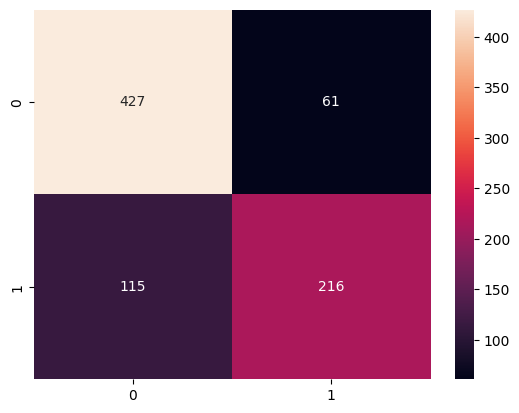

In [ ]:
print('Random Forest Classifier\n')
Rfc = RandomForestClassifier()
Rfc.fit(X_train, y_train)

y_Rfc = Rfc.predict(X_test)
print(metrics.classification_report(y_test, y_Rfc))
print(modelAccuracy.append(metrics.accuracy_score(y_test, y_Rfc)))

sns.heatmap(confusion_matrix(y_test, y_Rfc), annot=True, fmt='d')
plt.show()

# Inference:
427 values are correctly predicted as not potable water bodies and 216 values are correctly predicted as potable water bodies. 115 values are incorrectly predicted as not potable water bodies whereas 61 values are incorrectly predicted as potable.

XGB Classifier

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       488
           1       0.77      0.66      0.71       331

    accuracy                           0.78       819
   macro avg       0.78      0.76      0.77       819
weighted avg       0.78      0.78      0.78       819

None


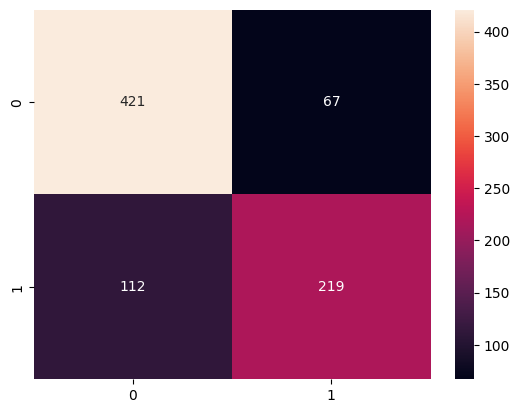

In [ ]:
print('XGB Classifier\n')
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_xgb = xgb.predict(X_test)
print(metrics.classification_report(y_test, y_xgb))
print(modelAccuracy.append(metrics.accuracy_score(y_test, y_xgb)))

sns.heatmap(confusion_matrix(y_test, y_xgb), annot=True, fmt='d')
plt.show()

# Inference:
421 values are correctly predicted as not potable water bodies and 219 values are correctly predicted as potable water bodies. 112 values are incorrectly predicted as not potable water bodies whereas 67 values are incorrectly predicted as potable.